In [1]:
import numpy as np

# Physical size of the world
world_size = 50.0

# Resolution control
voxel_size = 0.1  # smaller = higher resolution

# Number of voxels per axis
size = int(world_size / voxel_size)

cx, cy, cz = size // 2, size // 2, size // 2
center = np.array([cx, cy, cz])

space = np.zeros((size, size, size), dtype=np.float32)

center_world = np.array([cx * voxel_size, cy * voxel_size, cz * voxel_size])
radius = 10.0

x, y, z = np.indices((size, size, size))

x = x * voxel_size
y = y * voxel_size
z = z * voxel_size


dist2 = (
    (x - center_world[0])**2 +
    (y - center_world[1])**2 +
    (z - center_world[2])**2
)

space[dist2 <= radius**2] = 1



In [ ]:
#plot the sphere with matplotlib to verify the initialisation

""" #plot the sphere
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[space == 1], y[space == 1], z[space == 1], color='b', s=1)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_title('3D Sphere in Space')
plt.show() """

" #plot the sphere\nimport matplotlib.pyplot as plt\nfrom mpl_toolkits.mplot3d import Axes3D\n\nfig = plt.figure()\nax = fig.add_subplot(111, projection='3d')\nax.scatter(x[space == 1], y[space == 1], z[space == 1], color='b', s=1)\nax.set_xlabel('X axis')\nax.set_ylabel('Y axis')\nax.set_zlabel('Z axis')\nax.set_title('3D Sphere in Space')\nplt.show() "

In [ ]:
# Camera (ray origin) in voxel coordinates
cam = np.array([size//2, 0, size//2], dtype=np.float32)  # (x, y, z)

target = np.array([cx, cy, cz], dtype=np.float32)  # sphere center (cx, cy, cz)

forward = target - cam
forward /= np.linalg.norm(forward)  # normalize

#set up screen parameters
world_up = np.array([0.0, 0.0, 1.0], dtype=np.float32)
right = np.cross(forward, world_up)
right /= np.linalg.norm(right)  # normalize

up = np.cross(right, forward)
up /= np.linalg.norm(up)  # normalize

img_width = 500
img_height = 500

screen_dist = 5.0        # distance from camera
screen_width = 1.0       # physical width
screen_height = 1.0      # physical height
screen_center = cam + forward * screen_dist


In [4]:
screen_origin = (
    screen_center
    - (screen_width / 2) * right
    - (screen_height / 2) * up
)


# Pixel step in world units on the screen plane
pixel_dx = screen_width / img_width
pixel_dy = screen_height / img_height

# Pixel centers along each axis on the screen
u = (np.arange(img_width, dtype=np.float32) + 0.5) * pixel_dx   # (W,)
v = (np.arange(img_height, dtype=np.float32) + 0.5) * pixel_dy  # (H,)


In [5]:
# Expand so shapes broadcast: u -> (1, W, 1), v -> (H, 1, 1)
U = u[None, :, None]
V = v[:, None, None]

# Broadcast right/up to (1,1,3)
R = right[None, None, :]
Up = up[None, None, :]

# Pixel positions on the screen: (H, W, 3)
P = screen_origin[None, None, :] + U * R + V * Up



In [6]:
# Rays start at cam and go through each pixel point
D = P - cam[None, None, :]                 # (H, W, 3)
D /= np.linalg.norm(D, axis=-1, keepdims=True)  # normalize


In [10]:
print(P.shape, D.shape)      # (H, W, 3) (H, W, 3)
print(forward)
print(D[img_height//2, img_width//2])  # should be close to forward


(500, 500, 3) (500, 500, 3)
[0. 1. 0.]
[2.014160e-04 9.999999e-01 2.014160e-04]


In [8]:
# Sphere in the same coordinate system as cam/D
C = center.astype(np.float32)     # (3,)
R = float(radius)

# m = o - c  (same for all rays since o is fixed)
m = cam.astype(np.float32) - C    # (3,)

# Quadratic coefficients for ||(o + t d) - c||^2 = R^2
a = np.sum(D * D, axis=-1)                    # (H, W) ~ 1 if D normalized
b = 2.0 * np.sum(D * m[None, None, :], axis=-1)  # (H, W)
c = np.dot(m, m) - R * R                      # scalar

disc = b*b - 4.0*a*c                          # (H, W)

# Candidate hits where discriminant > 0
# clamp tiny negative discriminants to 0
disc = np.where((disc < 0.0) & (disc > -1e-16), 0.0, disc)

hit = disc >= 0.0
sqrt_disc = np.sqrt(np.maximum(disc, 0.0))


sign_b = np.where(b >= 0.0, 1.0, -1.0)

q = -0.5 * (b + sign_b * sqrt_disc)

# roots
t0 = np.where(hit, q / a, np.inf)
t1 = np.where(hit & (q != 0.0), c / q, np.inf)  # here c is your quadratic constant term


# Choose smallest t
t = np.minimum(t0, t1)


# white sphere on black background (uint8 image)
img = np.zeros((D.shape[1], D.shape[0]), dtype=np.uint8)
img[t < np.inf] = 255


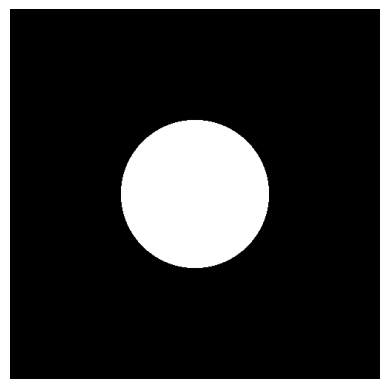

In [9]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(img, cmap="gray", vmin=0, vmax=255)
plt.axis("off")
plt.show()


In [25]:
#Add light source 
light_pos = np.array([size-3, 3, (size//2) -60], dtype=np.float32)  # light position at the top right corner of the world

#calculate normal at hit points
hit_points = cam[None, None, :] + t[..., None] * D  # (H, W, 3)
normals = hit_points - C[None, None, :]  # (H, W, 3)
normals /= np.linalg.norm(normals, axis=-1, keepdims=True)  # normalize normals

C:\Users\Ben\AppData\Local\Temp\ipykernel_34280\2485826854.py:7: RuntimeWarning: invalid value encountered in divide
  normals /= np.linalg.norm(normals, axis=-1, keepdims=True)  # normalize normals


C:\Users\Ben\AppData\Local\Temp\ipykernel_34280\3364196917.py:3: RuntimeWarning: invalid value encountered in divide
  light_dir /= np.linalg.norm(light_dir, axis=-1, keepdims=True)  # normalize light direction
C:\Users\Ben\AppData\Local\Temp\ipykernel_34280\3364196917.py:9: RuntimeWarning: invalid value encountered in cast
  img_lit = (diffuse * 255).astype(np.uint8)


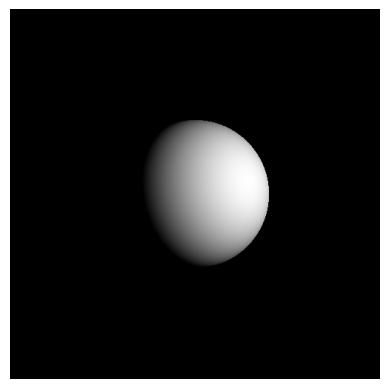

In [26]:
#use normals to calculate simple diffuse lighting
light_dir = light_pos - hit_points  # (H, W, 3)
light_dir /= np.linalg.norm(light_dir, axis=-1, keepdims=True)  # normalize light direction

diffuse = np.maximum(np.sum(normals * light_dir, axis=-1), 0.0)  # (H, W)

# Modulate the base color by the diffuse lighting
#
img_lit = (diffuse * 255).astype(np.uint8)
plt.figure()
plt.imshow(img_lit, cmap="gray", vmin=0, vmax=255)
plt.axis("off")
plt.show()